# Microwave acid digestion run analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# options: inline or widget
%matplotlib widget

In [2]:
class MADProfile(object):
    def __init__(self, filename, sample_info=None):
        self.read_multiwave_csv(filename)
        self.process_multiwave_metadata()
        self.sample_info = sample_info

    def read_multiwave_csv(self, filename):
        from datetime import datetime, timedelta
        with open(filename, encoding = "utf-16le") as multiwave_file:
            self.metadata = []
            for line in multiwave_file:
                self.metadata.append(line)
                if line.startswith('Result Data'):
                    break
            self.data = pd.read_csv(multiwave_file, sep='\t')
            self.data["Time"] = self.data["Time"].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S')#.time()
            ).apply(lambda t: timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())
        return self.data

    def process_multiwave_metadata(self):
        self.metadata = [tuple(l.strip().split('\t')) for l in self.metadata]
        try:
            self.warnings = self.metadata[self.metadata.index(('Warnings',))+1:-2]
            self.metadata = self.metadata[:self.metadata.index(('Warnings',))-1]
        except ValueError:
            self.warnings = None
            self.metadata = self.metadata[:-3]
        self.metadata = pd.Series({l[0]:l[1] if len(l)==2 else l[1:] for l in self.metadata if l[0]})
        self.vessels = int(self.metadata['Number of Vessels'])
        if self.vessels == 1:
            self.vessel_indices = (1,)
            self.plot_config = {'nrows':1, 'ncols':1}
        elif self.vessels == 3:
            self.vessel_indices = (3,7,11)
            self.plot_config = {'nrows':1, 'ncols':3}
        elif self.vessels == 4:
            self.vessel_indices = (1,4,7,10)
            self.plot_config = {'nrows':2, 'ncols':2}
        elif self.vessels == 6:
            self.vessel_indices = (1,3,5,7,9,11)
            self.plot_config = {'nrows':2, 'ncols':3}
        elif self.vessels == 8:
            self.vessel_indices = (2,3,5,6,8,9,11,12)
            self.plot_config = {'nrows':4, 'ncols':2}
        elif self.vessels == 12:
            self.vessel_indices = range(1,13)
            self.plot_config = {'nrows':4, 'ncols':3}
        else:
            raise NotImplementedError
        
    def plot(self):
        return self.data[[
            "Time"]+[f"T Pos. {i}" for i in self.vessel_indices]+["Power"
        ]].ffill().set_index("Time").plot.line()

    def identify_profile_features(self, sample, window_length=11, plateau_threshold=0.1, plateau_size=10, inflection_threshold = 0.02, peak_height=10, ax=None, legend=True):
        from scipy.signal import savgol_filter, find_peaks
        import numpy as np
        sample_data = pd.DataFrame({'raw':self.data.set_index('Time')[sample].dropna()})
        sample_data = sample_data.reset_index().drop_duplicates(['Time']).set_index('Time')
        sample_data['smooth'] = savgol_filter(sample_data['raw'], window_length=window_length, polyorder=2)
        with np.errstate(divide='ignore'):
            sample_data['diff'] = np.gradient(sample_data["smooth"], sample_data.index)
            sample_data['diff2nd'] = np.gradient(sample_data["diff"], sample_data.index)
        ax = sample_data.plot.line(ax=ax)
        # Identify key points (e.g., peaks or plateaus)
        key_points = np.where(np.abs(sample_data['diff']) < plateau_threshold)[0]  # Example threshold, start with 0.1
        sample_data['key_point'] = False
        sample_data.loc[sample_data.index[key_points], 'key_point'] = True
        ax.vlines(sample_data.index[key_points], ymin=0, ymax=5, linestyle='--', alpha=0.5)
        # Calculate plateau ranges
        plateaus = sample_data[sample_data.key_point == True].groupby(
            (sample_data.key_point != True).cumsum()
        ).apply(
            lambda x: pd.Series({
                'plateau_start':x.index.min(),
                'plateau_midpoint':x.index[len(x)//2],
                'plateau_end':x.index.max()
            })
        ).query(
            # Only select plateaus of a minimum size
            f"plateau_end - plateau_start >= {plateau_size}"
        ).reset_index(drop=True)
        sample_data = sample_data.join(
            plateaus.set_index('plateau_midpoint')
        )
        plateaus = sample_data[['smooth','plateau_start','plateau_end']].dropna().reset_index()
        ax.hlines(
            plateaus.smooth, xmin=plateaus.plateau_start, xmax=plateaus.plateau_end,
            linewidth=3, label='Plateaus', color='black', alpha=0.7, zorder=5
        )
        # Peaks
        peaks, peak_heights = find_peaks(sample_data.smooth, height=peak_height)
        sample_data['peak'] = False
        sample_data.loc[sample_data.index[peaks], 'peak'] = True
        ax.scatter(
            sample_data.index[peaks], sample_data.iloc[peaks]['smooth'],
            label='Peaks', color='green', alpha=0.7, zorder=5
        )
        # Detect inflection points (where second derivative changes sign)
        inflection_points = np.where(
            (np.diff(np.sign(sample_data['diff2nd'])) != 0) & 
            (np.abs(sample_data['diff2nd']) > inflection_threshold).iloc[:-1]
        )[0]
        #inflection_points = np.where(np.diff(np.sign(sample_data['diff2nd'])))[0]
        sample_data['inflection_point'] = False
        sample_data.loc[sample_data.index[inflection_points], 'inflection_point'] = True
        ax.scatter(
            sample_data.index[inflection_points], sample_data.iloc[inflection_points]['smooth'],
            label='Inflection points', color='purple', alpha=0.7, zorder=5
        )
        if not legend: ax.get_legend().remove()
            
        return sample_data, ax

    def profile_feature_analysis(self, window_length=11, plateau_threshold=0.1, plateau_size=10, inflection_threshold = 0.02, peak_height=10):
        samples = [f"T Pos. {i}" for i in self.vessel_indices]
        self.features = {}
        fig, axes = plt.subplots(nrows=self.plot_config['nrows'], ncols=self.plot_config['ncols'])
        for s, ax in zip(samples,axes.flatten()):
            ax.set_title(s)
            sd, _ = self.identify_profile_features(
                s, window_length=window_length, 
                plateau_threshold=plateau_threshold, 
                inflection_threshold = inflection_threshold,
                peak_height=peak_height, ax=ax, legend=False
            )
            self.features[s] = {
                'key_points':sd.key_point.sum(),
                'plateaus':len(sd.plateau_start.dropna()),
                'peaks':sd.peak.sum(),
                'inflections':sd.inflection_point.sum()
            }
        self.features = pd.DataFrame(self.features)


<Axes: xlabel='Time'>

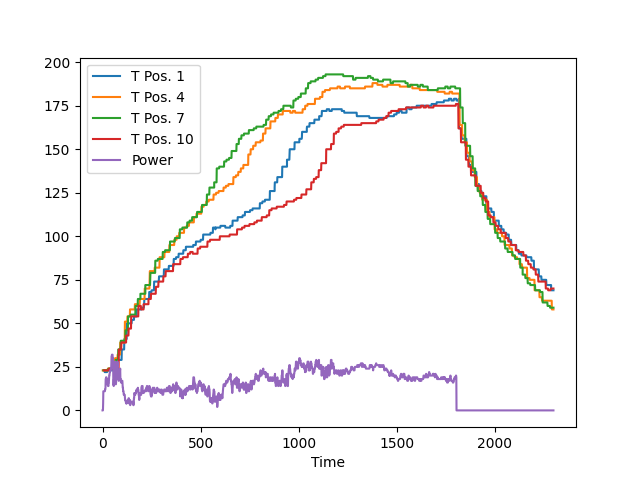

In [3]:
#! file -bi user/85000797 DSK0761_2.csv
mad_results = MADProfile('data/85000797_DSK0761_2.csv')
mad_results.plot()

<Axes: xlabel='Time'>

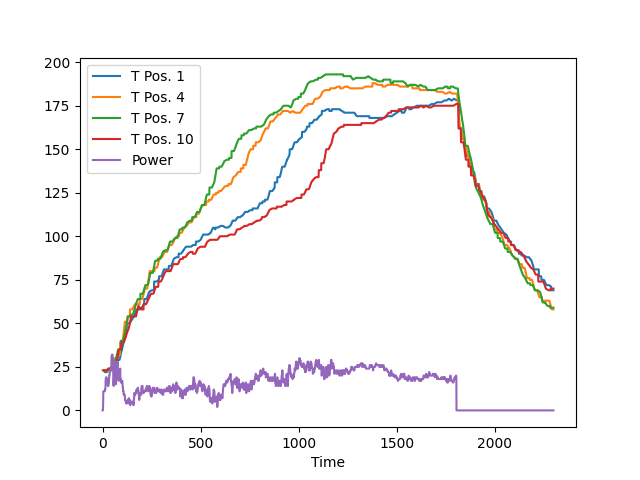

In [4]:
# Experiment with interpolation
mad_results.data[["Time","T Pos. 1","T Pos. 4","T Pos. 7","T Pos. 10","Power"]].set_index("Time").infer_objects(copy=False).interpolate().plot.line()

<Axes: xlabel='Time'>

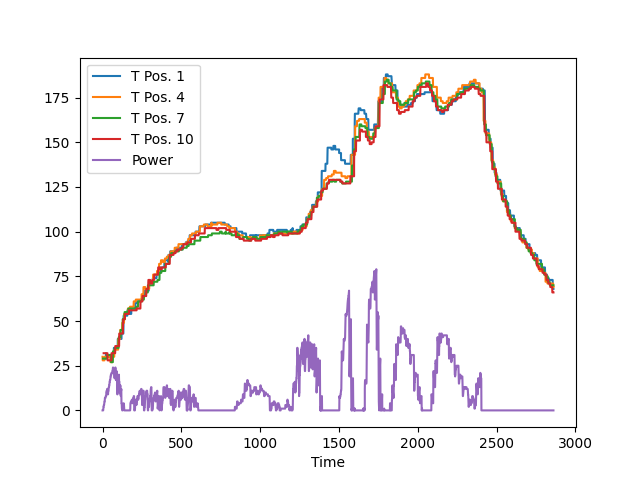

In [5]:
mad_results = MADProfile('data/500mg organic b ramp to 100.csv')
mad_results.plot()

## Analyze profile
### Profile for 1 sample

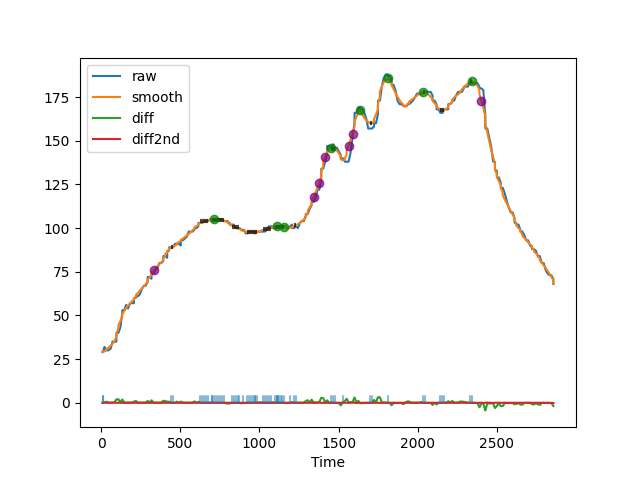

In [6]:
signal_settings = {
    'window_length': 20,
    'plateau_threshold': 0.05,
    'inflection_threshold': 0.05,
    'peak_height': 20
}
sample_data, ax = mad_results.identify_profile_features('T Pos. 1',**signal_settings)

### Profiles for all samples

             T Pos. 1  T Pos. 4  T Pos. 7  T Pos. 10
key_points         60        60        75         63
plateaus           13        11        14         14
peaks               8         8         7          9
inflections         7         5         7          5


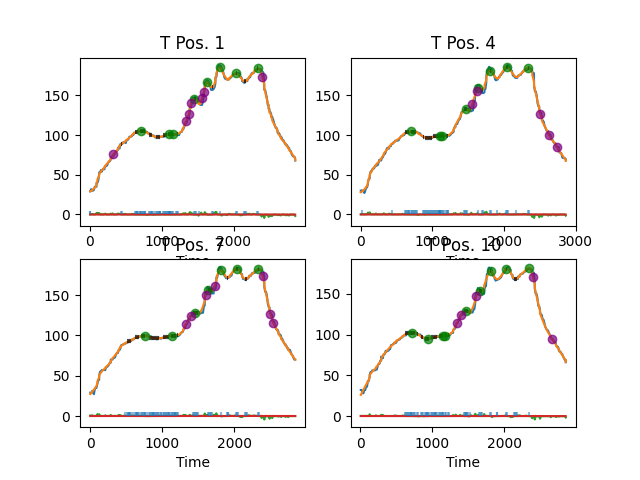

In [7]:
mad_results.profile_feature_analysis(**signal_settings)
print(mad_results.features)